## Sacramento Greenspace

<img src="sac-aerial.png" alt="Sacramento Aerial Landscape" width="730" height="470" longdesc="https://www.photopilot.com/blog/downtown-sacramento-california-state-capital" /> 

#### Introduction



#### Data Description


#### Data Citation


#### Methods



#### Analysis

Import Libraries

In [ ]:
import os
import pathlib
# Use regular expressions to extract metadata
import re 

# Process bit-wise cloud mask
import numpy as np 
# Group and aggregate
import pandas as pd
import matplotlib.pyplot as plt

# work with vector data
import geopandas as gpd 

# interactive plots of vector data
# add a tile map as a basemap to a plot with the tiles parameter
import hvplot.pandas

# Work with raster data
import rioxarray as rxr
from rioxarray.merge import merge_arrays # Merge rasters
import cartopy.crs as ccrs # CRSs

import earthaccess # Access NASA data from the cloud

import warnings
warnings.filterwarnings("ignore")

Retrieve Redlining Data

In [2]:
# create the project data directory
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'redlining',
)
os.makedirs(data_dir, exist_ok=True)

In [3]:
# Define url for redlining download
us_census_redlining_url = (
    "https://dsl.richmond.edu/panorama/redlining/static"
    "/mappinginequality.gpkg"
)

# Set up a path to save the data locally
redlining_dir = os.path.join(data_dir, 'redlining')

# Make the U.S. Census Survey directory
os.makedirs(redlining_dir, exist_ok=True)

# Join redlining geopackage path
redlining_map_path = os.path.join(redlining_dir, 'redlining.shp')

# Only download once and create GeoDataFrame
if not os.path.exists(redlining_map_path):
    redlining_gdf = gpd.read_file(us_census_redlining_url)
    redlining_gdf.to_file(redlining_map_path)

# Load from file
redlining_gdf = (
    gpd.read_file(redlining_map_path)
)

/var/folders/t3/h1jr9k717rsd7qwky1jw1bz00000gn/T/ipykernel_1915/1983433636.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  redlining_gdf.to_file(redlining_map_path)
/Users/laurenalexandra/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'city_survey' to 'city_surve'
  ogr_write(
/Users/laurenalexandra/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'residential' to 'residentia'
  ogr_write(
/Users/laurenalexandra/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/laurenalexandra/earth-analytics/data/redlining/redlining/redlining.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read

In [98]:
# Select city data 
sacramento_redlining_gdf = redlining_gdf.loc[redlining_gdf['city'] == 'Sacramento']

# Drop rows where column 'grade' is None
grade_gdf= sacramento_redlining_gdf.dropna(subset=['grade'])

# dissolve all the geometries within a given group (city) into a single geometric feature
# plot with EsriImagery basemap  
grade_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='HOLC Redlining of Sacramento',
    c="grade", line_color='darkgrey', line_width=3,
    frame_width=550
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (grade)

Process Multispectral Data

In [14]:
earthaccess.login(strategy="interactive", persist=True)

In [165]:
sacramento_results = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=tuple(sacramento_redlining_gdf.total_bounds),
    temporal=("2024-07-11"),
    count=100
)

In [166]:
landsat_data = earthaccess.open(sacramento_results)
landsat_data

QUEUEING TASKS | :   0%|          | 0/240 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/240 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/240 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10SFH.2024193T184504.v2.0/HLS.L30.T10SFH.2024193T184504.v2.0.B04.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10SFH.2024193T184504.v2.0/HLS.L30.T10SFH.2024193T184504.v2.0.B03.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10SFH.2024193T184504.v2.0/HLS.L30.T10SFH.2024193T184504.v2.0.B06.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10SFH.2024193T184504.v2.0/HLS.L30.T10SFH.2024193T184504.v2.0.Fmask.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10SFH.2024193T184504.v2.0/HLS.L30.T10SFH.2024193T184504.v2.0.VZA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.ear

In [167]:
def process_image(uri, bounds_gdf):
    """
    Load, crop, and scale a raster image from earthaccess

    Parameters
    ----------
    uri: file-like or path-like
      File accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """
    # load and scale
    da = rxr.open_rasterio(uri, mask_and_scale=True).squeeze()

    # obtain crs from raster
    reflectance_data_crs = da.rio.crs

    # match coordinate reference systems
    bounds_gdf = bounds_gdf.to_crs(reflectance_data_crs)

    # get study bounds da
    study_bounds = bounds_gdf.total_bounds

    # crop
    cropped_da = da.rio.clip_box(
      minx=study_bounds[0], 
      miny=study_bounds[1], 
      maxx=study_bounds[2], 
      maxy=study_bounds[3]
    )

    return cropped_da

In [168]:
def process_cloud_mask(cloud_uri, bits_to_mask):
    """
    Load an 8-bit Fmask file and process to a boolean mask

    Parameters
    ----------
    uri: file-like or path-like
      Fmask file accessor downloaded or obtained from earthaccess
    bits_to_mask: list of int
      The indices of the bits to mask if set

    Returns
    -------
    cloud_mask: np.array
      Cloud mask
    """
    cloud_da = rxr.open_rasterio(cloud_uri, mask_and_scale=True).squeeze()

    # Get the cloud mask as bits
    cloud_bits = (
        np.unpackbits(
            (
                # Get the cloud mask as an array...
                cloud_da.values
                # ... of 8-bit integers
                .astype('uint8')
                # With an extra axis to unpack the bits into
                [:, :, np.newaxis]
            ), 
            # List the least significat bit first to match the user guide
            bitorder='little',
            # Expand the array in a new dimension
            axis=-1)
    )
    
    # Add up the bits for each pixel
    cloud_mask = np.sum(
        # Select bits 
        cloud_bits[:,:,bits_to_mask], 
        # Sum along the bit axis
        axis=-1
    )

    # Mask the pixel if the sum is greater than 0
    # (If any of the bits are True)
    cloud_mask = cloud_mask == 0

    return cloud_mask

In [182]:
# Compile a regular expression to search for metadata
# Use () to select the desired name and only output that name
uri_re = re.compile(
    r"v2.0/(HLS.L30.*.tif)"
)
# Select unique granules
tile_id_re = re.compile(
    r"HLSL30.020/(HLS.L30..*.v2.0)/HLS"
)
# Grab band IDs
band_id_re = re.compile(
    r"HLS.L30..*v2.0.(\D{1}.*).tif"
)

# Find all the metadata in the file name 
uri_groups = []

for idx, uri in enumerate(landsat_data):
    # Make sure uri has full_name property first
    if (hasattr(uri, 'full_name')):
        file_name = uri_re.findall(uri.full_name)[0]
        tile_id = tile_id_re.findall(uri.full_name)[0]
        band_id = band_id_re.findall(uri.full_name)[0]

        uri_groups.append({
            'filename': file_name,
            'tile_id': tile_id,
            'band_id': band_id,
            'uri': uri
        })

# Create a DataFrame with the File-like URI
raster_df = pd.DataFrame(data=uri_groups, columns=['filename', 'tile_id', 'band_id', 'uri'])

# Only keep spectral bands and cloud Fmask
exclude_files = ['VAA', 'VZA', 'SAA', 'SZA']
# Select data not in the excluded files list
raster_df = raster_df[~raster_df['band_id'].isin(exclude_files)]

# Check the results
raster_df

,filename,tile_id,band_id,uri
0,HLS.L30.T10SFH.2024193T184504.v2.0.B04.tif,HLS.L30.T10SFH.2024193T184504.v2.0,B04,"<File-like object HTTPFileSystem, https://data..."
1,HLS.L30.T10SFH.2024193T184504.v2.0.B03.tif,HLS.L30.T10SFH.2024193T184504.v2.0,B03,"<File-like object HTTPFileSystem, https://data..."
2,HLS.L30.T10SFH.2024193T184504.v2.0.B06.tif,HLS.L30.T10SFH.2024193T184504.v2.0,B06,"<File-like object HTTPFileSystem, https://data..."
3,HLS.L30.T10SFH.2024193T184504.v2.0.Fmask.tif,HLS.L30.T10SFH.2024193T184504.v2.0,Fmask,"<File-like object HTTPFileSystem, https://data..."
7,HLS.L30.T10SFH.2024193T184504.v2.0.B07.tif,HLS.L30.T10SFH.2024193T184504.v2.0,B07,"<File-like object HTTPFileSystem, https://data..."
...,...,...,...,...
233,HLS.L30.T10SFH.2024313T184542.v2.0.B11.tif,HLS.L30.T10SFH.2024313T184542.v2.0,B11,"<File-like object HTTPFileSystem, https://data..."
234,HLS.L30.T10SFH.2024313T184542.v2.0.B04.tif,HLS.L30.T10SFH.2024313T184542.v2.0,B04,"<File-like object HTTPFileSystem, https://data..."
237,HLS.L30.T10SFH.2024313T184542.v2.0.B09.tif,HLS.L30.T10SFH.2024313T184542.v2.0,B09,"<File-like object HTTPFileSystem, https://data..."
238,HLS.L30.T10SFH.2024313T184542.v2.0.B05.tif,HLS.L30.T10SFH.2024313T184542.v2.0,B05,"<File-like object HTTPFileSystem, https://data..."


In [183]:
# All bands
bands = {
    'B01': 'aerosol',
    'B02': 'red',
    'B03': 'green',
    'B04': 'blue',
    'B05': 'nir',
    'B06': 'swir1',
    'B07': 'swir2',
    'B09': 'cirrus',
    'B10': 'thermalir1',
    'B11': 'thermalir2'
}
bits_to_mask = [
    1, # Cloud
    2, # Adjacent to cloud
    3, # Cloud shadow
    5  # Water (to not confuse with greenspace)
]
# Initialize structure for saving images
sac_das = {band_name: [] for band_name in bands.keys()}

# unique data granules
tile_groups = raster_df.groupby('tile_id')

for tile_name, tile_df in tile_groups:
    # Grab Fmask row from tile group
    Fmask_row = tile_df.loc[tile_df['band_id'] == 'Fmask']
    # Load the cloud mask
    cloud_path = Fmask_row.uri.values[0]
    cloud_mask = process_cloud_mask(cloud_path, bits_to_mask)

    # Load spectral bands
    band_groups = raster_df.groupby('band_id')
    keep_bands = ['B03', 'B02', 'B05']
    for band_name, band_df in band_groups:
        if band_name in keep_bands:
            for index, row in tile_df.iterrows():
                # Process band
                cropped_da = process_image(row.uri, sacramento_redlining_gdf)

                # Apply mask on band to remove unwanted cloud data
                cloud_masked_da = cropped_da.where(~cropped_da.isin(cloud_mask))

                # Store the resulting DataArray
                sac_das[band_name].append(cloud_masked_da)

sac_das

{'B01': [],
 'B02': [<xarray.DataArray (y: 337, x: 281)> Size: 379kB
  array([[0.058     , 0.0777    , 0.0822    , ..., 0.1409    , 0.1304    ,
          0.118     ],
         [0.0595    , 0.1017    , 0.16409999, ..., 0.1481    , 0.12889999,
          0.1328    ],
         [0.0681    , 0.095     , 0.1775    , ..., 0.16049999, 0.1452    ,
          0.131     ],
         ...,
         [0.08639999, 0.11229999, 0.16149999, ..., 0.24509999, 0.192     ,
          0.1618    ],
         [0.105     , 0.0949    , 0.1281    , ..., 0.22129999, 0.1724    ,
          0.1156    ],
         [0.1192    , 0.0871    , 0.1108    , ..., 0.2306    , 0.1502    ,
          0.0926    ]], dtype=float32)
  Coordinates:
      band         int64 8B 1
    * x            (x) float64 2kB 6.29e+05 6.29e+05 ... 6.374e+05 6.374e+05
    * y            (y) float64 3kB 4.276e+06 4.276e+06 ... 4.266e+06 4.266e+06
      spatial_ref  int64 8B 0
  Attributes: (12/33)
      ACCODE:                    Lasrc; Lasrc
      arop_ave

In [185]:
sac_das_merged = {}

# Merge all tiles
for band_name, das in sac_das.items():
    if band_name in keep_bands:
        merged = merge_arrays(das)
        sac_das_merged[band_name] = merged

In [189]:
# Calculate Normalized Difference Vegetation Index (NDVI)

sac_ndvi_da = (
    (sac_das_merged['B05'] - sac_das_merged['B02'])
    / (sac_das_merged['B05'] + sac_das_merged['B02'])
)

Inspect Reflectance

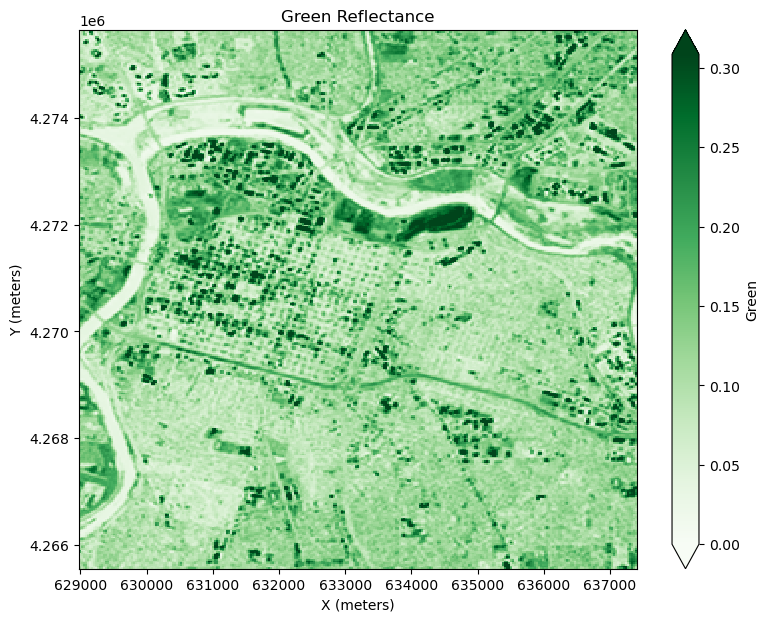

In [191]:
# test green

fig = plt.figure(figsize=(9, 7)) 
ax = plt.axes()

city_green_plt = sac_das_merged['B03'].plot(cmap='Greens', vmin=0, robust=True, cbar_kwargs={'label': 'Green'})

plt.title('Green Reflectance')
# based on the CRS projection 
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')

fig.savefig("green-reflectance.png") 

city_green_plt

In [190]:
%store sac_ndvi_da sac_das_merged

Stored 'sac_ndvi_da' (DataArray)
Stored 'sac_das_merged' (dict)


#### Discussion



#### References

The pandas development team. (2024). *pandas-dev/pandas: Pandas* (Version 2.2.2) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.3509134